## Group 3 - Project 2
# Online Shopper Purchase Prediction

In [17]:
#Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA

import model as Group3Models

import xgboost as xgb
from sklearn.ensemble import AdaBoostClassifier



In [18]:
#Read in CSV
online_shopping_df = pd.read_csv('online_shoppers_intention.csv')

online_shopping_df.info()

online_shopping_df["Revenue"].value_counts()

# online_shopping_df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12330 entries, 0 to 12329
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Administrative           12330 non-null  int64  
 1   Administrative_Duration  12330 non-null  float64
 2   Informational            12330 non-null  int64  
 3   Informational_Duration   12330 non-null  float64
 4   ProductRelated           12330 non-null  int64  
 5   ProductRelated_Duration  12330 non-null  float64
 6   BounceRates              12330 non-null  float64
 7   ExitRates                12330 non-null  float64
 8   PageValues               12330 non-null  float64
 9   SpecialDay               12330 non-null  float64
 10  Month                    12330 non-null  object 
 11  OperatingSystems         12330 non-null  int64  
 12  Browser                  12330 non-null  int64  
 13  Region                   12330 non-null  int64  
 14  TrafficType           

Revenue
False    10422
True      1908
Name: count, dtype: int64

In [19]:
online_shopping_df.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,1,1,1,1,Returning_Visitor,False,False
1,0,0.0,0,0.0,2,64.000000,0.00,0.10,0.0,0.0,Feb,2,2,1,2,Returning_Visitor,False,False
2,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,4,1,9,3,Returning_Visitor,False,False
3,0,0.0,0,0.0,2,2.666667,0.05,0.14,0.0,0.0,Feb,3,2,2,4,Returning_Visitor,False,False
4,0,0.0,0,0.0,10,627.500000,0.02,0.05,0.0,0.0,Feb,3,3,1,4,Returning_Visitor,True,False


## Visualize PCA

In [20]:
pca_model = PCA(n_components=2)

<Axes: xlabel='OperatingSystems', ylabel='Count'>

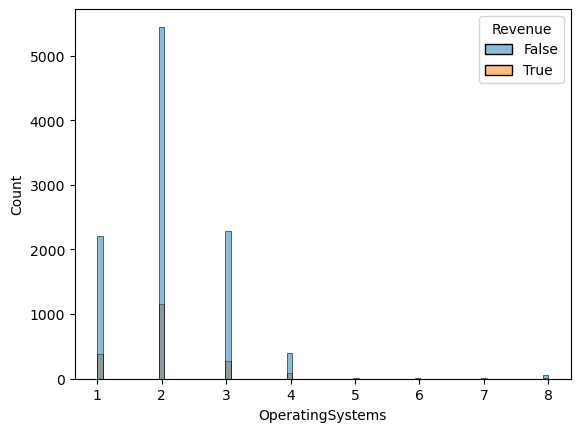

In [21]:
#EDA
sns.histplot(data=online_shopping_df, x='OperatingSystems', hue='Revenue')

<Axes: xlabel='ExitRates', ylabel='Count'>

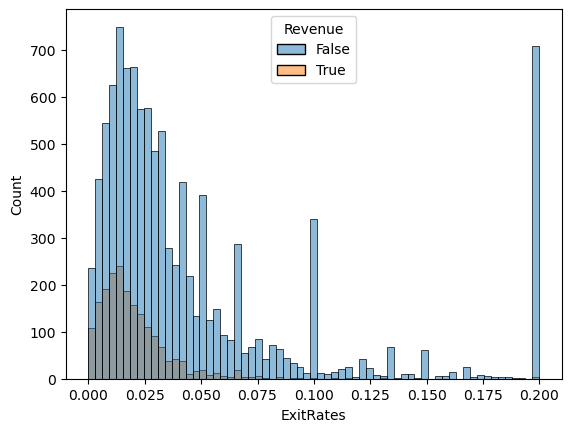

In [22]:
sns.histplot(data=online_shopping_df, x='ExitRates', hue='Revenue')

In [23]:
#Drop the target column, setup X and y datasets for train test split
X = online_shopping_df.drop('Revenue', axis=1)
y = online_shopping_df['Revenue']

X.head()

#Train Test Split
X_test, X_train, y_test, y_train = train_test_split(X, y)
X_train.describe()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,OperatingSystems,Browser,Region,TrafficType
count,3083.000000,3083.000000,3083.000000,3083.000000,3083.000000,3083.000000,3083.000000,3083.000000,3083.000000,3083.000000,3083.000000,3083.000000,3083.000000,3083.00000
mean,2.343497,83.106058,0.493351,32.867182,31.343172,1197.885579,0.022662,0.043794,5.635247,0.062147,2.110931,2.315602,3.165099,4.08628
std,3.399204,182.256439,1.344421,144.571383,44.403915,1920.466749,0.048801,0.048665,17.661271,0.200658,0.886861,1.616744,2.416212,3.99566
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.00000
25%,0.000000,0.000000,0.000000,0.000000,7.000000,181.183333,0.000000,0.014378,0.000000,0.000000,2.000000,2.000000,1.000000,2.00000
50%,1.000000,6.000000,0.000000,0.000000,17.000000,585.391667,0.003478,0.025901,0.000000,0.000000,2.000000,2.000000,3.000000,2.00000
75%,4.000000,94.920000,0.000000,0.000000,37.000000,1430.552083,0.018182,0.050000,0.000000,0.000000,3.000000,2.000000,4.000000,4.00000
max,26.000000,2629.253968,24.000000,2256.916667,705.000000,43171.233380,0.200000,0.200000,361.763742,1.000000,8.000000,13.000000,9.000000,20.00000


## Add Encodings to Feature Columns

In [24]:
#Encode VisitorType Column
ordinal_encoder = OrdinalEncoder()
X_train['VisitorType'] = ordinal_encoder.fit_transform(X_train[['VisitorType']])

#Ordinal Encode the Month Column
ordinal_encoder = OrdinalEncoder(categories=[['Jan', 'Feb', 'Mar', 'Apr', 'May', 'June', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']])
X_train['Month'] = ordinal_encoder.fit_transform(X_train[['Month']])
X_train.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend
2844,11,498.9,3,147.166667,43,1090.060606,0.004082,0.011338,4.759935,0.0,4.0,1,2,4,5,2.0,False
4091,0,0.0,0,0.000000,2,10.000000,0.000000,0.100000,0.000000,0.0,4.0,1,1,1,3,2.0,False
968,0,0.0,0,0.000000,33,3506.166667,0.000000,0.025000,0.000000,0.0,2.0,1,1,1,1,2.0,True
1335,1,3.0,2,373.000000,6,66.833333,0.000000,0.012500,0.000000,0.0,2.0,2,4,1,8,0.0,False
1604,0,0.0,0,0.000000,9,381.000000,0.000000,0.025000,0.000000,0.0,2.0,2,2,6,2,0.0,False


In [25]:
#Encode VisitorType Column
ordinal_encoder = OrdinalEncoder()
ordinal_encoder.fit(X_test[['VisitorType']])
X_test['VisitorType'] = ordinal_encoder.transform(X_test[['VisitorType']])

#Ordinal Encode the Month Column
ordinal_encoder = OrdinalEncoder(categories=[['Jan', 'Feb', 'Mar', 'Apr', 'May', 'June', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']])
X_test['Month'] = ordinal_encoder.fit_transform(X_test[['Month']])

<Axes: >

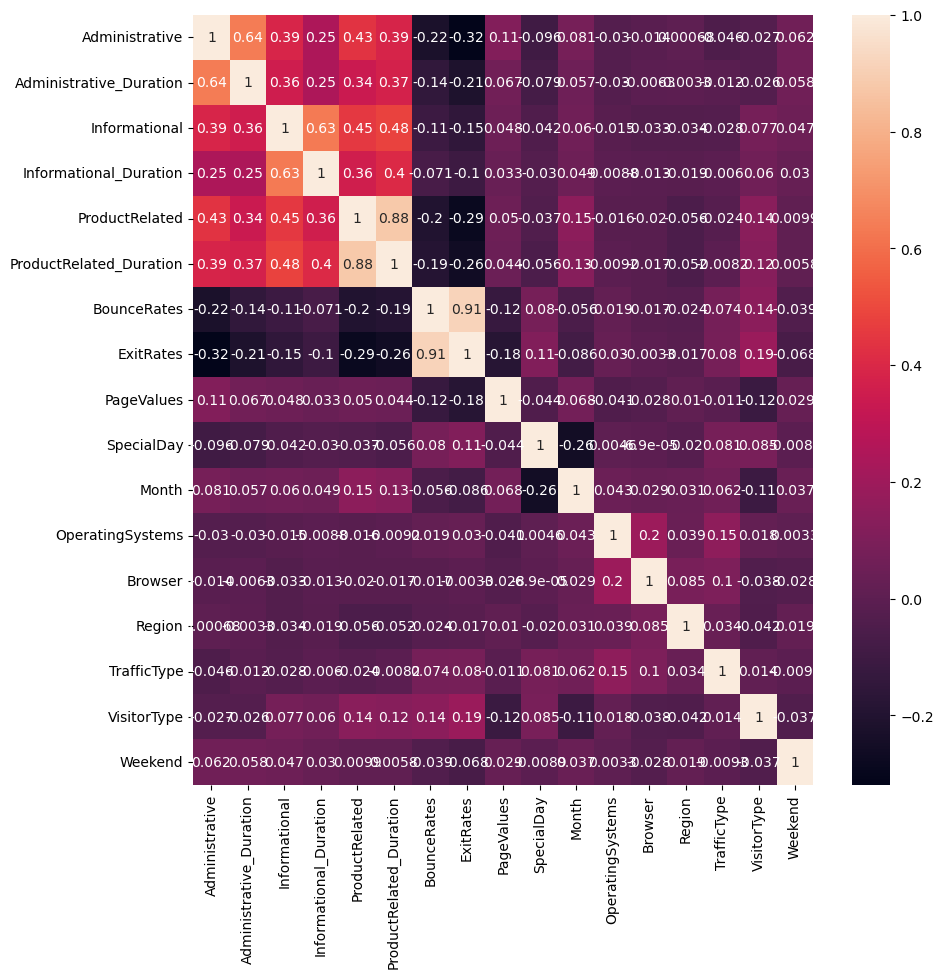

In [26]:
plt.figure(figsize=(10, 10))
sns.heatmap(data=X_train.corr(), annot=True)

## Create a Model and predict

Train Model Score:  1.0
Test Model Score:  0.8888288093435709
Accuracy Score: 0.8888288093435709
Balanced Accuracy Score: 0.7675436149538619
              precision    recall  f1-score   support

       False       0.93      0.94      0.93      7816
        True       0.66      0.59      0.62      1431

    accuracy                           0.89      9247
   macro avg       0.79      0.77      0.78      9247
weighted avg       0.88      0.89      0.89      9247



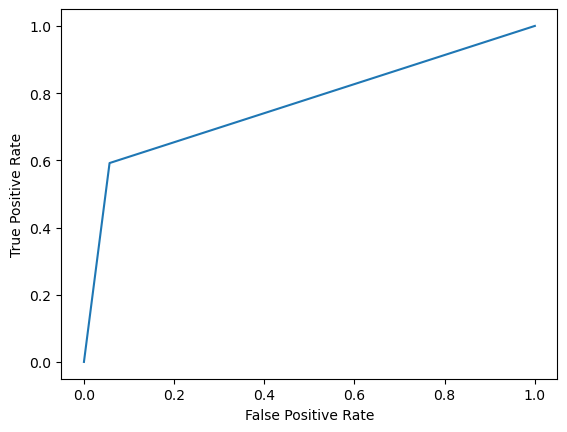

AUC Score: 0.767543614953862


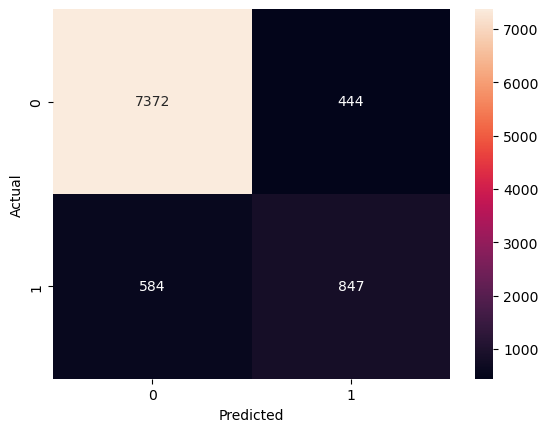

In [27]:
model = Group3Models.model_xgboost_V1(X_train, y_train)
Group3Models.evaluate_model(model, X_train, y_train, X_test, y_test)

Fitting 5 folds for each of 405 candidates, totalling 2025 fits
[CV 1/5] END colsample_bytree=0.6, gamma=0.5, max_depth=3, min_child_weight=1, subsample=0.6;, score=0.912 total time=   0.0s
[CV 2/5] END colsample_bytree=0.6, gamma=0.5, max_depth=3, min_child_weight=1, subsample=0.6;, score=0.896 total time=   0.0s
[CV 3/5] END colsample_bytree=0.6, gamma=0.5, max_depth=3, min_child_weight=1, subsample=0.6;, score=0.900 total time=   0.0s
[CV 4/5] END colsample_bytree=0.6, gamma=0.5, max_depth=3, min_child_weight=1, subsample=0.6;, score=0.914 total time=   0.0s
[CV 5/5] END colsample_bytree=0.6, gamma=0.5, max_depth=3, min_child_weight=1, subsample=0.6;, score=0.891 total time=   0.0s
[CV 1/5] END colsample_bytree=0.6, gamma=0.5, max_depth=3, min_child_weight=1, subsample=0.8;, score=0.911 total time=   0.0s
[CV 2/5] END colsample_bytree=0.6, gamma=0.5, max_depth=3, min_child_weight=1, subsample=0.8;, score=0.890 total time=   0.0s
[CV 3/5] END colsample_bytree=0.6, gamma=0.5, max_dept

c:\Users\hunte\anaconda3\envs\dev\lib\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


              precision    recall  f1-score   support

       False       0.93      0.95      0.94      7816
        True       0.69      0.62      0.65      1431

    accuracy                           0.90      9247
   macro avg       0.81      0.78      0.80      9247
weighted avg       0.89      0.90      0.90      9247



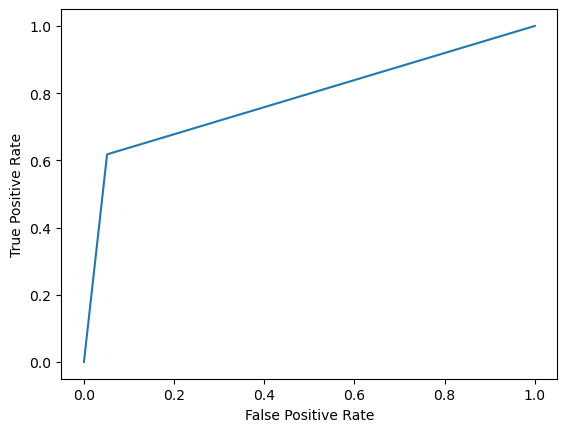

AUC Score: 0.7832224049719366


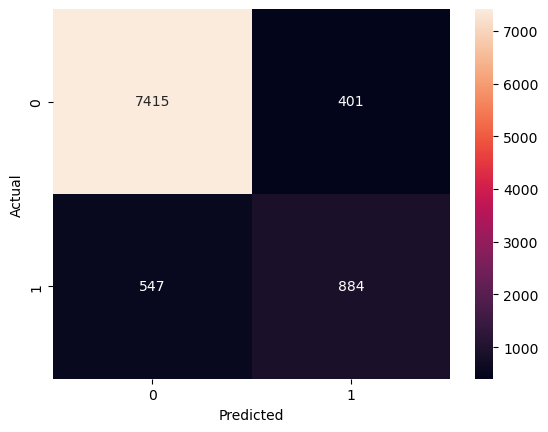

In [28]:
model = Group3Models.model_xgboost_V2(X_train, y_train)
Group3Models.evaluate_model(model, X_train, y_train, X_test, y_test)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5] END colsample_bytree=0.6, gamma=2, max_depth=3, min_child_weight=10, subsample=0.8;, score=0.916 total time=   0.0s
[CV 2/5] END colsample_bytree=0.6, gamma=2, max_depth=3, min_child_weight=10, subsample=0.8;, score=0.903 total time=   0.0s
[CV 3/5] END colsample_bytree=0.6, gamma=2, max_depth=3, min_child_weight=10, subsample=0.8;, score=0.895 total time=   0.0s
[CV 4/5] END colsample_bytree=0.6, gamma=2, max_depth=3, min_child_weight=10, subsample=0.8;, score=0.909 total time=   0.0s
[CV 5/5] END colsample_bytree=0.6, gamma=2, max_depth=3, min_child_weight=10, subsample=0.8;, score=0.899 total time=   0.0s
[CV 1/5] END colsample_bytree=1.0, gamma=1, max_depth=4, min_child_weight=10, subsample=0.8;, score=0.906 total time=   0.0s
[CV 2/5] END colsample_bytree=1.0, gamma=1, max_depth=4, min_child_weight=10, subsample=0.8;, score=0.903 total time=   0.0s
[CV 3/5] END colsample_bytree=1.0, gamma=1, max_depth=4, min_chi

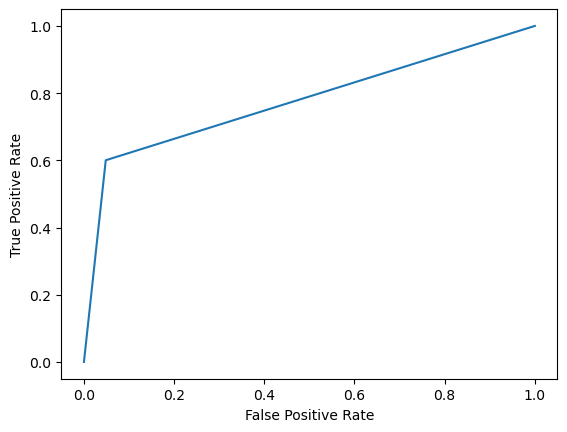

AUC Score: 0.7759585955666564


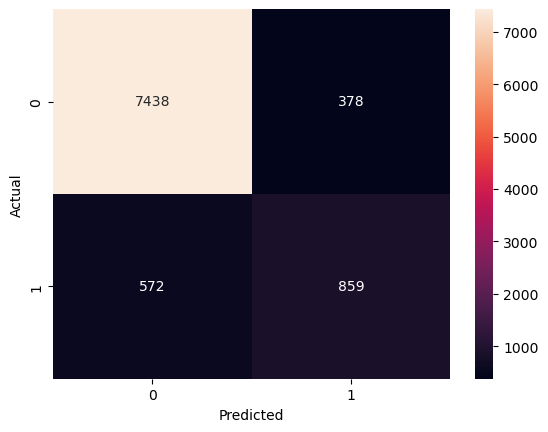

In [29]:
model = Group3Models.model_xgboost_V3(X_train, y_train)
Group3Models.evaluate_model(model, X_train, y_train, X_test, y_test)

c:\Users\hunte\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Train Model Score:  0.9098280895231917
Test Model Score:  0.8928301070617498
Accuracy Score: 0.8928301070617498
Balanced Accuracy Score: 0.7759046826127416
              precision    recall  f1-score   support

       False       0.93      0.95      0.94      7816
        True       0.67      0.61      0.64      1431

    accuracy                           0.89      9247
   macro avg       0.80      0.78      0.79      9247
weighted avg       0.89      0.89      0.89      9247



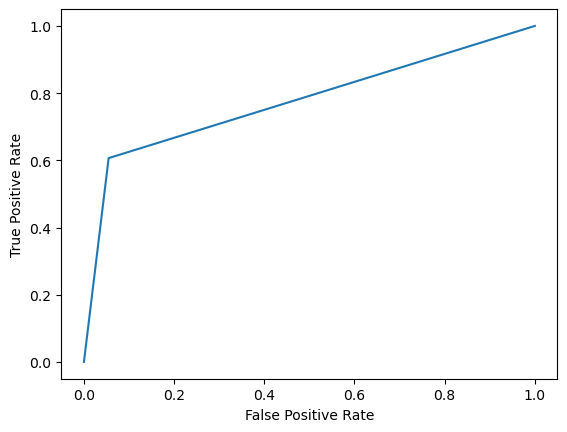

AUC Score: 0.7759046826127416


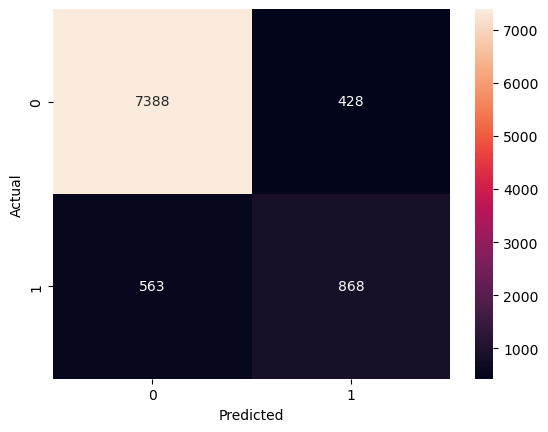

In [30]:
model = Group3Models.model_adaboost_V1(X_train, y_train)
Group3Models.evaluate_model(model, X_train, y_train, X_test, y_test)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV 1/5] END learning_rate=0.1, n_estimators=50;, score=0.888 total time=   0.0s


c:\Users\hunte\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\hunte\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 2/5] END learning_rate=0.1, n_estimators=50;, score=0.908 total time=   0.0s
[CV 3/5] END learning_rate=0.1, n_estimators=50;, score=0.895 total time=   0.0s


c:\Users\hunte\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\hunte\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 4/5] END learning_rate=0.1, n_estimators=50;, score=0.904 total time=   0.0s
[CV 5/5] END learning_rate=0.1, n_estimators=50;, score=0.875 total time=   0.0s


c:\Users\hunte\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\hunte\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 1/5] END learning_rate=0.1, n_estimators=100;, score=0.895 total time=   0.1s
[CV 2/5] END learning_rate=0.1, n_estimators=100;, score=0.908 total time=   0.1s


c:\Users\hunte\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\hunte\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 3/5] END learning_rate=0.1, n_estimators=100;, score=0.891 total time=   0.1s
[CV 4/5] END learning_rate=0.1, n_estimators=100;, score=0.909 total time=   0.1s


c:\Users\hunte\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\hunte\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 5/5] END learning_rate=0.1, n_estimators=100;, score=0.883 total time=   0.1s


c:\Users\hunte\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 1/5] END learning_rate=0.1, n_estimators=200;, score=0.895 total time=   0.3s


c:\Users\hunte\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 2/5] END learning_rate=0.1, n_estimators=200;, score=0.908 total time=   0.3s


c:\Users\hunte\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 3/5] END learning_rate=0.1, n_estimators=200;, score=0.890 total time=   0.3s


c:\Users\hunte\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 4/5] END learning_rate=0.1, n_estimators=200;, score=0.904 total time=   0.3s


c:\Users\hunte\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 5/5] END learning_rate=0.1, n_estimators=200;, score=0.885 total time=   0.3s
[CV 1/5] END learning_rate=0.5, n_estimators=50;, score=0.901 total time=   0.0s
[CV 2/5] END learning_rate=0.5, n_estimators=50;, score=0.908 total time=   0.0s


c:\Users\hunte\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\hunte\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\hunte\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 3/5] END learning_rate=0.5, n_estimators=50;, score=0.890 total time=   0.0s
[CV 4/5] END learning_rate=0.5, n_estimators=50;, score=0.909 total time=   0.0s
[CV 5/5] END learning_rate=0.5, n_estimators=50;, score=0.888 total time=   0.0s


c:\Users\hunte\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\hunte\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\hunte\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 1/5] END learning_rate=0.5, n_estimators=100;, score=0.903 total time=   0.1s


c:\Users\hunte\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 2/5] END learning_rate=0.5, n_estimators=100;, score=0.903 total time=   0.1s


c:\Users\hunte\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 3/5] END learning_rate=0.5, n_estimators=100;, score=0.885 total time=   0.1s
[CV 4/5] END learning_rate=0.5, n_estimators=100;, score=0.904 total time=   0.1s


c:\Users\hunte\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\hunte\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 5/5] END learning_rate=0.5, n_estimators=100;, score=0.893 total time=   0.1s


c:\Users\hunte\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 1/5] END learning_rate=0.5, n_estimators=200;, score=0.908 total time=   0.3s


c:\Users\hunte\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 2/5] END learning_rate=0.5, n_estimators=200;, score=0.890 total time=   0.3s


c:\Users\hunte\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 3/5] END learning_rate=0.5, n_estimators=200;, score=0.883 total time=   0.3s


c:\Users\hunte\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 4/5] END learning_rate=0.5, n_estimators=200;, score=0.906 total time=   0.3s


c:\Users\hunte\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 5/5] END learning_rate=0.5, n_estimators=200;, score=0.894 total time=   0.4s
[CV 1/5] END ..learning_rate=1, n_estimators=50;, score=0.906 total time=   0.0s
[CV 2/5] END ..learning_rate=1, n_estimators=50;, score=0.893 total time=   0.0s


c:\Users\hunte\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\hunte\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\hunte\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\hunte\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this wa

[CV 3/5] END ..learning_rate=1, n_estimators=50;, score=0.887 total time=   0.0s
[CV 4/5] END ..learning_rate=1, n_estimators=50;, score=0.903 total time=   0.0s
[CV 5/5] END ..learning_rate=1, n_estimators=50;, score=0.894 total time=   0.0s


c:\Users\hunte\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 1/5] END .learning_rate=1, n_estimators=100;, score=0.904 total time=   0.1s
[CV 2/5] END .learning_rate=1, n_estimators=100;, score=0.890 total time=   0.1s


c:\Users\hunte\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\hunte\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 3/5] END .learning_rate=1, n_estimators=100;, score=0.891 total time=   0.1s


c:\Users\hunte\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 4/5] END .learning_rate=1, n_estimators=100;, score=0.894 total time=   0.1s
[CV 5/5] END .learning_rate=1, n_estimators=100;, score=0.899 total time=   0.1s


c:\Users\hunte\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\hunte\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 1/5] END .learning_rate=1, n_estimators=200;, score=0.895 total time=   0.3s


c:\Users\hunte\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 2/5] END .learning_rate=1, n_estimators=200;, score=0.891 total time=   0.3s


c:\Users\hunte\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 3/5] END .learning_rate=1, n_estimators=200;, score=0.888 total time=   0.3s


c:\Users\hunte\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 4/5] END .learning_rate=1, n_estimators=200;, score=0.894 total time=   0.3s


c:\Users\hunte\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 5/5] END .learning_rate=1, n_estimators=200;, score=0.899 total time=   0.3s
Best parameters found:  {'learning_rate': 0.5, 'n_estimators': 50}
Best score found:  0.8991238502178535
Train Model Score:  0.9996756406097956
Test Model Score:  0.8895858116145777
Accuracy Score: 0.8895858116145777
Balanced Accuracy Score: 0.7682768490086811
              precision    recall  f1-score   support

       False       0.93      0.94      0.94      7816
        True       0.66      0.59      0.62      1431

    accuracy                           0.89      9247
   macro avg       0.79      0.77      0.78      9247
weighted avg       0.89      0.89      0.89      9247



c:\Users\hunte\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


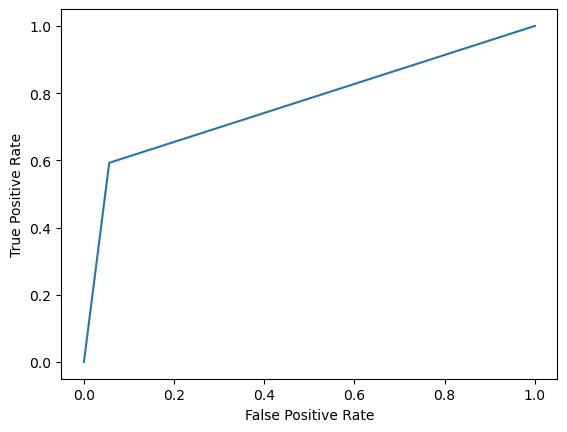

AUC Score: 0.7682768490086812


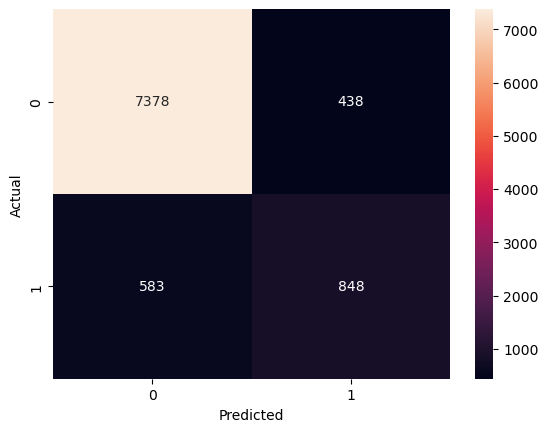

In [31]:
model = Group3Models.model_adaboost_V2(X_train, y_train)
Group3Models.evaluate_model(model, X_train, y_train, X_test, y_test)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV 1/5] END learning_rate=0.1, n_estimators=50;, score=0.888 total time=   0.0s


c:\Users\hunte\anaconda3\envs\dev\lib\site-packages\sklearn\model_selection\_search.py:320: UserWarning: The total space of parameters 9 is smaller than n_iter=10. Running 9 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
c:\Users\hunte\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\hunte\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 2/5] END learning_rate=0.1, n_estimators=50;, score=0.908 total time=   0.0s
[CV 3/5] END learning_rate=0.1, n_estimators=50;, score=0.895 total time=   0.0s


c:\Users\hunte\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\hunte\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 4/5] END learning_rate=0.1, n_estimators=50;, score=0.904 total time=   0.0s
[CV 5/5] END learning_rate=0.1, n_estimators=50;, score=0.875 total time=   0.0s


c:\Users\hunte\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\hunte\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 1/5] END learning_rate=0.1, n_estimators=100;, score=0.895 total time=   0.1s
[CV 2/5] END learning_rate=0.1, n_estimators=100;, score=0.908 total time=   0.1s


c:\Users\hunte\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\hunte\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 3/5] END learning_rate=0.1, n_estimators=100;, score=0.891 total time=   0.1s


c:\Users\hunte\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 4/5] END learning_rate=0.1, n_estimators=100;, score=0.909 total time=   0.2s


c:\Users\hunte\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 5/5] END learning_rate=0.1, n_estimators=100;, score=0.883 total time=   0.1s


c:\Users\hunte\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 1/5] END learning_rate=0.1, n_estimators=200;, score=0.895 total time=   0.3s


c:\Users\hunte\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 2/5] END learning_rate=0.1, n_estimators=200;, score=0.908 total time=   0.3s


c:\Users\hunte\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 3/5] END learning_rate=0.1, n_estimators=200;, score=0.890 total time=   0.3s


c:\Users\hunte\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 4/5] END learning_rate=0.1, n_estimators=200;, score=0.904 total time=   0.3s


c:\Users\hunte\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 5/5] END learning_rate=0.1, n_estimators=200;, score=0.885 total time=   0.3s
[CV 1/5] END learning_rate=0.5, n_estimators=50;, score=0.901 total time=   0.0s


c:\Users\hunte\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\hunte\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 2/5] END learning_rate=0.5, n_estimators=50;, score=0.908 total time=   0.0s
[CV 3/5] END learning_rate=0.5, n_estimators=50;, score=0.890 total time=   0.0s


c:\Users\hunte\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\hunte\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 4/5] END learning_rate=0.5, n_estimators=50;, score=0.909 total time=   0.0s
[CV 5/5] END learning_rate=0.5, n_estimators=50;, score=0.888 total time=   0.0s


c:\Users\hunte\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\hunte\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 1/5] END learning_rate=0.5, n_estimators=100;, score=0.903 total time=   0.1s
[CV 2/5] END learning_rate=0.5, n_estimators=100;, score=0.903 total time=   0.1s


c:\Users\hunte\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\hunte\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 3/5] END learning_rate=0.5, n_estimators=100;, score=0.885 total time=   0.1s
[CV 4/5] END learning_rate=0.5, n_estimators=100;, score=0.904 total time=   0.1s


c:\Users\hunte\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\hunte\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 5/5] END learning_rate=0.5, n_estimators=100;, score=0.893 total time=   0.1s


c:\Users\hunte\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 1/5] END learning_rate=0.5, n_estimators=200;, score=0.908 total time=   0.3s


c:\Users\hunte\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 2/5] END learning_rate=0.5, n_estimators=200;, score=0.890 total time=   0.3s


c:\Users\hunte\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 3/5] END learning_rate=0.5, n_estimators=200;, score=0.883 total time=   0.3s


c:\Users\hunte\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 4/5] END learning_rate=0.5, n_estimators=200;, score=0.906 total time=   0.3s


c:\Users\hunte\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 5/5] END learning_rate=0.5, n_estimators=200;, score=0.894 total time=   0.3s
[CV 1/5] END ..learning_rate=1, n_estimators=50;, score=0.906 total time=   0.0s
[CV 2/5] END ..learning_rate=1, n_estimators=50;, score=0.893 total time=   0.0s


c:\Users\hunte\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\hunte\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\hunte\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 3/5] END ..learning_rate=1, n_estimators=50;, score=0.887 total time=   0.0s
[CV 4/5] END ..learning_rate=1, n_estimators=50;, score=0.903 total time=   0.0s


c:\Users\hunte\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\hunte\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 5/5] END ..learning_rate=1, n_estimators=50;, score=0.894 total time=   0.0s
[CV 1/5] END .learning_rate=1, n_estimators=100;, score=0.904 total time=   0.1s


c:\Users\hunte\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\hunte\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 2/5] END .learning_rate=1, n_estimators=100;, score=0.890 total time=   0.1s
[CV 3/5] END .learning_rate=1, n_estimators=100;, score=0.891 total time=   0.1s


c:\Users\hunte\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\hunte\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 4/5] END .learning_rate=1, n_estimators=100;, score=0.894 total time=   0.1s
[CV 5/5] END .learning_rate=1, n_estimators=100;, score=0.899 total time=   0.1s


c:\Users\hunte\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\hunte\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 1/5] END .learning_rate=1, n_estimators=200;, score=0.895 total time=   0.3s


c:\Users\hunte\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 2/5] END .learning_rate=1, n_estimators=200;, score=0.891 total time=   0.3s


c:\Users\hunte\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 3/5] END .learning_rate=1, n_estimators=200;, score=0.888 total time=   0.3s


c:\Users\hunte\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 4/5] END .learning_rate=1, n_estimators=200;, score=0.894 total time=   0.3s


c:\Users\hunte\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 5/5] END .learning_rate=1, n_estimators=200;, score=0.899 total time=   0.3s
Best parameters found:  {'n_estimators': 50, 'learning_rate': 0.5}
Best score found:  0.8991238502178535
Train Model Score:  0.9996756406097956
Test Model Score:  0.8895858116145777
Accuracy Score: 0.8895858116145777
Balanced Accuracy Score: 0.7682768490086811
              precision    recall  f1-score   support

       False       0.93      0.94      0.94      7816
        True       0.66      0.59      0.62      1431

    accuracy                           0.89      9247
   macro avg       0.79      0.77      0.78      9247
weighted avg       0.89      0.89      0.89      9247



c:\Users\hunte\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


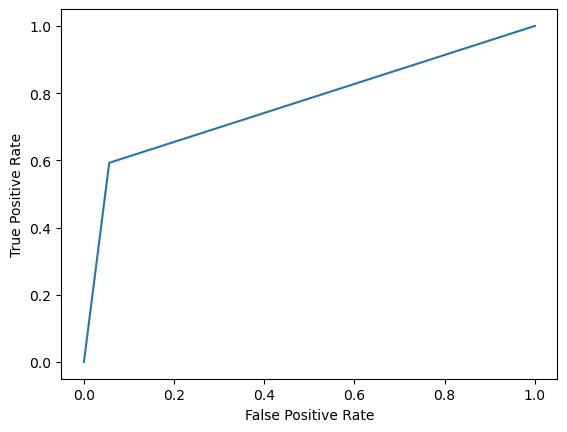

AUC Score: 0.7682768490086812


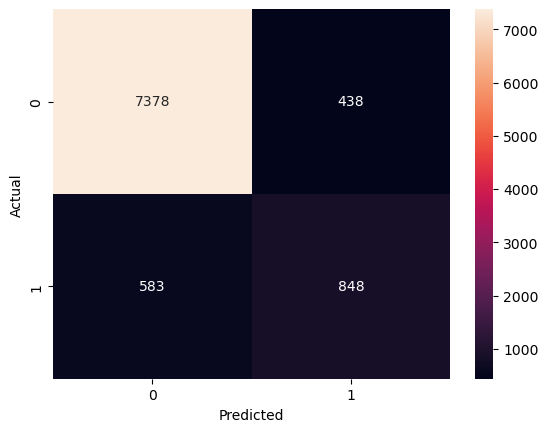

In [32]:
model = Group3Models.model_adaboost_V3(X_train, y_train)
Group3Models.evaluate_model(model, X_train, y_train, X_test, y_test)